In [1]:
import torch
import matplotlib.pyplot as plt

This is used to generate fake labels for given data

In [2]:
def generate_fake_labels(x3, x2, x1):
    return (x3**3 * 0.8) + (x2**2 * 0.1) + (x1 * 0.5) + 4.

In [3]:
x = torch.tensor([[0.7,0.3,0.7], [0.4, 1., 0.4], [0.2, 1.1, 0.1], [0.4, 0.7, 0.2], [0.1, 0.5, 0.3]])
y = torch.tensor([generate_fake_labels(i[0],i[1],i[2]) for i in x])
x.shape, y.shape, y

(torch.Size([5, 3]),
 torch.Size([5]),
 tensor([4.6334, 4.3512, 4.1774, 4.2002, 4.1758]))

In [4]:
class model:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
        self._initalize_parameters()
        self._initalize_moms()
        self._initalize_RMSs()
    
    def _initalize_parameters(self):
        self.weights_1 = self._random_tensor((x.shape[1],3))
        self.bias_1 = self._random_tensor(1)
        self.weights_2 = self._random_tensor((3,1))
        self.bias_2 = self._random_tensor(1)
    
    def _random_tensor(self, size): return (torch.randn(size)).requires_grad_()
    
    def _initalize_moms(self):
        self.moms_w1, self.moms_b1 = [0], [0]
        self.moms_w2, self.moms_b2 = [0], [0]
    
    def _initalize_RMSs(self):
        self.RMSs_w1, self.RMSs_b1 = [0], [0]
        self.RMSs_w2, self.RMSs_b2 = [0], [0]

    def _nn(self, xb):
        l1 = xb @ self.weights_1 + self.bias_1
        l2 = l1.max(torch.tensor(0.0))
        l3 = l2 @ self.weights_2 + self.bias_2
        return l3
    
    def _loss_func(self, preds, yb): return ((preds-yb)**2).mean()
    
    def train(self, optimizer):
        # Multiple learning rates to see how optimizers work with them
        lrs = [10E-4,10E-3,10E-2,10E-1]
        ## for plotting ##
        fig, axs = plt.subplots(2,2)
        ## for plotting ##
        all_losses = []
        for i, lr in enumerate(lrs):
            losses = []
            while(len(losses) == 0 or losses[-1] > 0.1 and len(losses) < 1000):
                preds = self._nn(self.x)
                loss = self._loss_func(preds, self.y)
                loss.backward()

                optimizer(self.weights_1, lr, self.moms_w1, self.RMSs_w1)
                optimizer(self.bias_1, lr, self.moms_b1, self.RMSs_b1)
                optimizer(self.weights_2, lr, self.moms_w2, self.RMSs_w2)
                optimizer(self.bias_2, lr, self.moms_b2, self.RMSs_b2)

                losses.append(loss.item())
            all_losses.append(losses)
            
            ## for plotting ##
            xi = i%2
            yi = int(i/2)
            axs[xi,yi].plot(list(range(len(losses))), losses)
            axs[xi,yi].set_ylim(0, 30)
            axs[xi,yi].set_title('Learing Rate: '+str(lr))
            ## for plotting ##
            
            # Setting seed makes sure the parameters are initalized the same way for better comparison
            torch.manual_seed(42)
            self._initalize_parameters()
            self._initalize_moms()
            self._initalize_RMSs()
        
        ## for plotting ##
        for ax in axs.flat:
            ax.set(xlabel='steps', ylabel='loss (MSE)')
        plt.tight_layout()
        ## for plotting ##

In [5]:
my_model = model(x, y)

## Vanilla stochastic gradient descent

In [6]:
def SGD(a, lr, _, __):
    a.data -= a.grad * lr
    a.grad = None

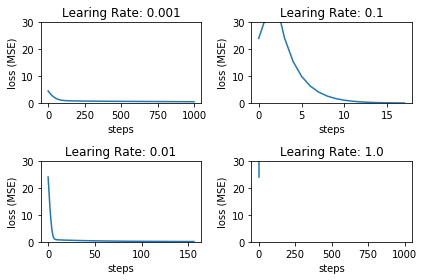

In [7]:
my_model.train(SGD)

## Momentum

Notice that this doesn't require learning rate.

In [8]:
def momentum(a, _, moms, __):
    previous_momentum = moms[-1]
    
    mom = a.grad * 0.1 + previous_momentum * 0.9
    moms.append(mom)
    a.data -= mom
    a.grad = None

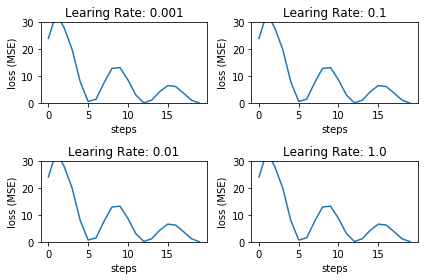

In [9]:
my_model.train(momentum)

## RMSprop

In [10]:
def RMSprop(a, lr, _, RMSs):
    previous_RMS = RMSs[-1]
    
    RMS = (a.grad ** 2 * 0.1 + previous_RMS * 0.9)
    RMSs.append(RMS)
    # Gamma is added to make sure there is never divide with zero
    gamma = 1E-5
    a.data -= (a.grad * lr) / (torch.sqrt(RMS) + gamma)
    a.grad = None

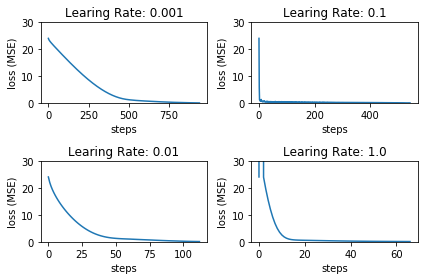

In [11]:
my_model.train(RMSprop)

## Adam

Adam = Momentum + RMSprop

In [12]:
def Adam(a, lr, moms, RMSs):
    previous_momentum = moms[-1]
    mom = a.grad * 0.1 + previous_momentum * 0.9
    moms.append(mom)
    
    previous_RMS = RMSs[-1]
    RMS = a.grad ** 2 * 0.1 + previous_RMS * 0.9
    RMSs.append(RMS)
    
    gamma = 1E-5
    a.data -= (mom * lr) / (torch.sqrt(RMS) + gamma)
    a.grad = None

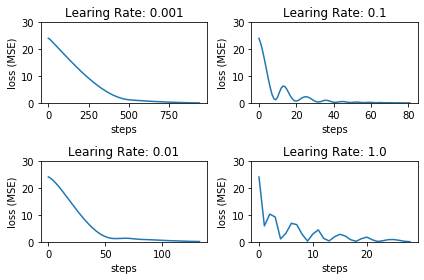

In [13]:
my_model.train(Adam)